In [27]:
# Import
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse.linalg import eigs
from scipy.optimize import minimize

In [28]:
# Functions
def chebyshev_points(n, alpha=1):
    # Classical Chebyshev points
    xi_cheb = np.cos(np.linspace(0, np.pi, n))
    
    # Exponentially stretched Chebyshev points
    xi_stretched = np.sign(xi_cheb) * np.abs(xi_cheb)**alpha

    return xi_stretched


def chebyshev_matrix(n, alpha=1):
    # Generate exponentially stretched Chebyshev points
    xi = chebyshev_points(n, alpha=alpha)
    
    # Initialize differentiation matrix
    D = np.zeros((n, n))
    C = np.ones(n)
    C[0] = 2
    C[-1] = 2
    
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = C[i] * (-1)**(i + j) / (C[j] * (xi[i] - xi[j]))
            elif i == 0:
                D[i, i] = (2 * (n - 1)**2 + 1) / 6
            elif i == n - 1:
                D[i, i] = -(2 * (n - 1)**2 + 1) / 6
            else:
                D[i, i] = -xi[i] / (2 * (1 - xi[i]**2))
    
    return D, xi


def chebyshev_matrix_scale(n, r1, r2, alpha=1):
    # Get Chebyshev matrix and stretched points
    D, xi = chebyshev_matrix(n, alpha=alpha)
    
    # Scale the differentiation matrix and points
    DScale = D * 2 / (r2 - r1)
    xiScale = ((r2 - r1) / 2) * xi + ((r1 + r2) / 2)
    
    return DScale, xiScale

def B_mat(r):
    B = np.eye(4*nbPoint)
    B[3*nbPoint:4*nbPoint, 3*nbPoint:4*nbPoint] = 0
    return B


def A_mat(r,D,m,beta,nu,rho,r1,r2,w1,w2):
    C1 = (r2**2*w2-r1**2*w1)/(r2**2-r1**2)
    C2 = (r2**2*r1**2)/(r2**2-r1**2)*(w1-w2)
    U = C1*r + C2/r

    # Creation of the matrix A with bloc Aij, i being the line and j the column
    A11 = nu * D @ D + nu * np.diag(1/r) @ D - np.diag(U) @ np.diag(1/r) * 1j * m - nu * (((m**2 + 1) * np.diag(1/(r**2))) + (np.eye(nbPoint) * (beta ** 2)))
    A12 = 2 * np.diag(U) @ np.diag(1/r) - nu * 2 * 1j * m * np.diag(1/(r**2))
    A13 = np.zeros((nbPoint, nbPoint))
    A14 = - (1 / rho) * D
    
    A21 = - np.diag(U) @ np.diag(1/r) - D @ np.diag(U) + nu * 2 * 1j * m * np.diag(1/(r)**2)
    A22 = nu * D @ D + nu * np.diag(1/r) @ D - np.diag(U) @ np.diag(1/r) * 1j * m - nu * (((m**2 + 1) * np.diag(1/(r**2))) + (np.eye(nbPoint) * (beta ** 2)))
    A23 = np.zeros((nbPoint, nbPoint))
    A24 = - (1 / rho) * 1j * m * np.diag(1/r)
    
    A31 = np.zeros((nbPoint, nbPoint))
    A32 = np.zeros((nbPoint, nbPoint))
    A33 = nu * D @ D + nu * np.diag(1/r) @ D - np.diag(U) @ np.diag(1/r) * 1j * m - nu * (((m**2) * np.diag(1/(r**2))) + (np.eye(nbPoint) * (beta ** 2)))
    A34 = - (1 / rho) * 1j * beta * np.eye(nbPoint)
    
    A41 = D + np.diag(1/r)
    A42 = 1j * m * np.diag(1/r)
    A43 = 1j * beta * np.eye(nbPoint)
    A44 = np.zeros((nbPoint, nbPoint))

    A = np.block([[A11, A12, A13, A14],
                  [A21, A22, A23, A24],
                  [A31, A32, A33, A34],
                  [A41, A42, A43, A44]])

    return A

def setBCs(A, B):
    # Dirichlet at R1
    A[[0, nbPoint, 2 * nbPoint], :] = 0
    A[[0, nbPoint, 2 * nbPoint], [0, nbPoint, 2 * nbPoint]] = 1
    B[[0, nbPoint, 2 * nbPoint], :] = 0
    # Dirichlet at R2
    A[[nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1], :] = 0
    A[[nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1], [nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1]] = 1
    B[[nbPoint - 1, 2 * nbPoint - 1, 3 * nbPoint - 1], :] = 0

def Solve_EVP(nbPoint,m,beta,nu,rho,r1,r2,omega1, omega2):
    D, r = chebyshev_matrix_scale(nbPoint,r1,r2)
    
    A = A_mat(r,D,m,beta,nu,rho,r1,r2,omega1, omega2)
    B = B_mat(r)
    #B += np.eye(B.shape[0]) * 1e-15
    setBCs(A, B)

    eigenvalues, eigenvectors = eig(A, B)

    return eigenvalues, eigenvectors


def beta_objective(beta):
    return calculate_Recr1(beta, eta, r1, r2, nu)

def calculate_Recr1(beta, eta, r1, r2, nu):
    omega2 = Re2 * nu / (r2 * (r2 - r1))
    
    def Re1_objective(Re1):
        omega1 = Re1 * nu / (r1 * (r2 - r1))
        
        eigenvalues, eigenvectors = Solve_EVP(nbPoint, m, beta, nu, rho, r1, r2, omega1, omega2)
        finite_indices = np.isfinite(eigenvalues)
        filtered_eigenvalues = eigenvalues[finite_indices]
        real_lambda = np.real(filtered_eigenvalues)
        if np.any((real_lambda > 0)):
            return Re1
        else:
            return 1e8 #Large value in case of no real_lambda > 0 found
            
    result = minimize(Re1_objective, x0=10000, bounds=[(0, 1e8)])
    return result.fun

In [29]:
Re1c_min = []
eta_array_min = []

# Parameters
nbPoint = 20
rho = 1
nu = 1
m = 0 # From literature, we know that the first unstable mode appearing when Re2=0 should appear with m=0
Re2 = 0

for eta in np.arange(0.01, 1, 0.01):
    r1 = eta / (1 - eta)
    r2 = 1 / (1 - eta)
    
    def beta_objective(beta):
        return calculate_Recr1(beta, eta, r1, r2, nu)
    
    beta_result = minimize(beta_objective, x0=5, bounds=[(0, 1e8)])
    if beta_result.success:
        min_Re1_for_eta = beta_result.fun
        Re_cr1_theo = 1 / (0.155**2) * (1 + eta)**2 / (2 * eta * ((1 - eta) * (3 + eta))**(1/2))
        print(f"eta={round(eta,2)} | Recr1/Recr1_theoretical={round(min_Re1_for_eta/Re_cr1_theo,2)} | Recr1_theoretical={round(Re_cr1_theo,2)} | Recr1={round(min_Re1_for_eta,2)}")
        eta_array_min.append(eta)
        Re1c_min.append(min_Re1_for_eta)

eta_array_min = np.array(eta_array_min)

eta=0.01 | Recr1/Recr1_theoretical=81311.41 | Recr1_theoretical=1229.84 | Recr1=100000000.0
eta=0.02 | Recr1/Recr1_theoretical=13.31 | Recr1_theoretical=629.3 | Recr1=8377.93
eta=0.03 | Recr1/Recr1_theoretical=8.16 | Recr1_theoretical=429.29 | Recr1=3501.67
eta=0.04 | Recr1/Recr1_theoretical=6.23 | Recr1_theoretical=329.41 | Recr1=2053.71
eta=0.05 | Recr1/Recr1_theoretical=5.21 | Recr1_theoretical=269.59 | Recr1=1404.94
eta=0.06 | Recr1/Recr1_theoretical=435168.6 | Recr1_theoretical=229.8 | Recr1=100000000.0
eta=0.07 | Recr1/Recr1_theoretical=4.1 | Recr1_theoretical=201.45 | Recr1=825.25
eta=0.08 | Recr1/Recr1_theoretical=554760.0 | Recr1_theoretical=180.26 | Recr1=100000000.0
eta=0.09 | Recr1/Recr1_theoretical=3.53 | Recr1_theoretical=163.84 | Recr1=577.73
eta=0.1 | Recr1/Recr1_theoretical=3.34 | Recr1_theoretical=150.76 | Recr1=503.19
eta=0.11 | Recr1/Recr1_theoretical=713699.38 | Recr1_theoretical=140.12 | Recr1=100000000.0
eta=0.12 | Recr1/Recr1_theoretical=3.07 | Recr1_theoretical

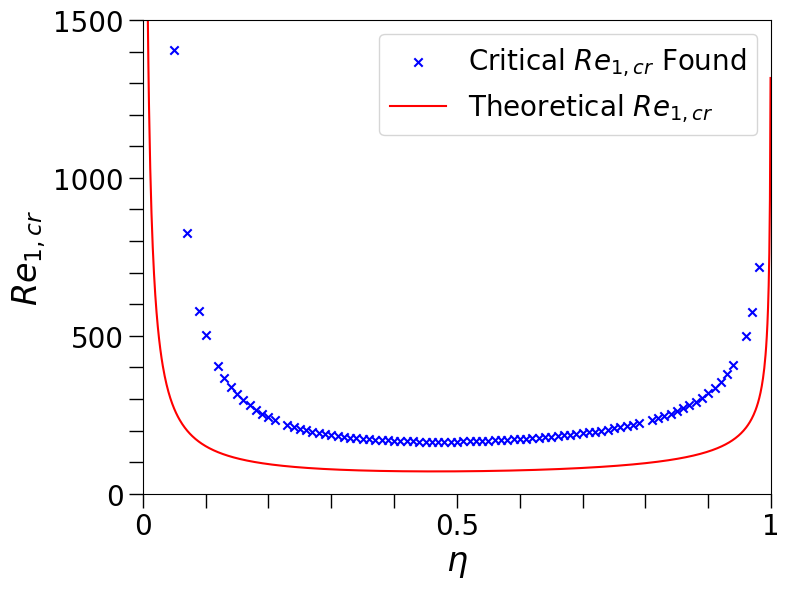

In [32]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(eta_array_min, np.array(Re1c_min), label='Critical $Re_{1,cr}$ Found', color='blue',marker='x')

eta_theor = np.linspace(0.001, 1 - 0.001, 1000)
Re1_cr_theor = 1 / (0.155**2) * (1 + eta_theor)**2 / (2 * eta_theor * ((1 - eta_theor) * (3 + eta_theor))**(1/2))

plt.plot(eta_theor, Re1_cr_theor, label='Theoretical $Re_{1,cr}$', color='red')
plt.xlim([0, 1])
plt.ylim([0, 1500])
plt.xlabel('$\\eta$', fontsize=24)
plt.ylabel('$Re_{1,cr}$', fontsize=24)
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
           labels=['0', '', '', '', '', '0.5', '', '', '', '', '1'],
           fontsize=20)
plt.yticks(ticks=np.arange(0,1500+100,100),
           labels=[f'{label_val}' if label_val%500==0 else f'' for label_val in np.arange(0,1500+100,100) if label_val%100==0],
           fontsize=20)
plt.tick_params(axis='both', which='major', length=10, width=1)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Re1cr_vs_eta.png",dpi=1000)
plt.show()

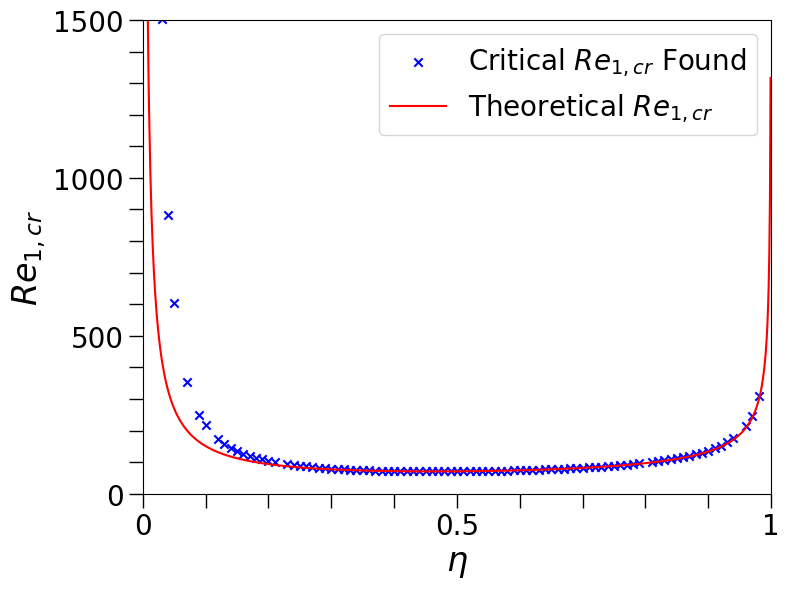

In [33]:
##########################################################################################################################################################
# Carefull!!! Here we divide the Re1c_min values obtained by a constant to shift the curve to investigate if the shape of the curve we obtain is correct #
##########################################################################################################################################################

Dividing_factor = 2.33

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(eta_array_min, np.array(Re1c_min)/Dividing_factor, label='Critical $Re_{1,cr}$ Found', color='blue',marker='x')

eta_theor = np.linspace(0.001, 1 - 0.001, 1000)
Re1_cr_theor = 1 / (0.155**2) * (1 + eta_theor)**2 / (2 * eta_theor * ((1 - eta_theor) * (3 + eta_theor))**(1/2))

plt.plot(eta_theor, Re1_cr_theor, label='Theoretical $Re_{1,cr}$', color='red')
plt.xlim([0, 1])
plt.ylim([0, 1500])
plt.xlabel('$\\eta$', fontsize=24)
plt.ylabel('$Re_{1,cr}$', fontsize=24)
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
           labels=['0', '', '', '', '', '0.5', '', '', '', '', '1'],
           fontsize=20)
plt.yticks(ticks=np.arange(0,1500+100,100),
           labels=[f'{label_val}' if label_val%500==0 else f'' for label_val in np.arange(0,1500+100,100) if label_val%100==0],
           fontsize=20)
plt.tick_params(axis='both', which='major', length=10, width=1)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f"Re1cr_vs_eta_divided_by_{Dividing_factor}.png",dpi=1000)
plt.show()